# FINAL EXAM - UAS DEEP LEARNING No 2

---



---



Nama : Agnes Calista

NIM : 2501980690

Link Video : https://youtu.be/DpIhEsz2bsQ

## import libraries

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,LSTM, Dense, Flatten, Embedding

import re
import keras
from keras import Model
from tensorflow.keras.layers import Flatten,LSTM, Dense, Flatten, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from keras.initializers import glorot_uniform
from sklearn import model_selection
import keras.layers as layers

import csv
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## import dataset & preprocessing

In [ ]:
dfAMZN = pd.read_csv("AMZN.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
dfAMZN.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [ ]:
# Buat variabel baru yang berisi
pricesAmazon = pd.DataFrame(dfAMZN["Close"]).rename(columns={"Close": "Price"})
pricesAmazon.head()

,Price
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


In [ ]:

WINDOW_SIZE = 5

HORIZON = 5

Memisahkan data n data time series tersebut
menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan
horizon = 5 [dari hari senin s.d jumat].

In [ ]:
# Get AMZN date array
timesteps1 = pricesAmazon.index.to_numpy()
prices1 = pricesAmazon["Price"].to_numpy()

timesteps1[:10], prices1[:10]

(array(['1997-05-15T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
        '1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', '1997-05-27T00:00:00.000000000',
        '1997-05-28T00:00:00.000000000', '1997-05-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
        1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

code diatas untuk mempersiapkan timestamps dan price dalam format yang sesuai untuk proses selanjutnya. Code diatas untuk mengambil timesteps dan harga saham dari dataframe pricesAmazon kemudian mengubahnya dalam numpy array.

In [ ]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(6)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5] -> Label: 6


In [ ]:
def make_windows(x, window_size=5, horizon=1):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows1, full_labels1 = make_windows(prices1, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows1), len(full_labels1)

(5753, 5753)

## Create train tes val split

In [ ]:
def make_train_val_test_splits(windows, labels, val_split=0.1, test_split=0.1):

    total_size = len(windows)
    train_size = int(total_size * 0.8)
    val_size = int(total_size * 0.1)
    test_size = total_size - train_size - val_size

    train_windows = windows[:train_size]
    train_labels = labels[:train_size]
    val_windows = windows[train_size:train_size+val_size]
    val_labels = labels[train_size:train_size+val_size]
    test_windows = windows[train_size+val_size:]
    test_labels = labels[train_size+val_size:]

    return train_windows, val_windows, test_windows, train_labels, val_labels, test_labels

In [ ]:
train_windows1, val_windows1, test_windows1, train_labels1, val_labels1, test_labels1= make_train_val_test_splits(full_windows1, full_labels1)
print("Train set length:", len(train_windows1))
print("Validation set length:", len(val_windows1))
print("Test set length:", len(test_windows1))
print("Train labels length:", len(train_labels1))
print("Validation labels length:", len(val_labels1))
print("Test labels length:", len(test_labels1))

Train set length: 4602
Validation set length: 575
Test set length: 576
Train labels length: 4602
Validation labels length: 575
Test labels length: 576


In [ ]:
print('Train set: {} baris , {} kolom'.format(train_windows1.shape[0], train_windows1.shape[1]))
print('Test set: {} baris , {} kolom'.format(test_windows1.shape[0], test_windows1.shape[1]))
print('Validation set: {} baris , {} kolom'.format(val_windows1.shape[0], val_windows1.shape[1]))

Train set: 4602 baris , 5 kolom
Test set: 576 baris , 5 kolom
Validation set: 575 baris , 5 kolom


In [ ]:
# Scaling training set
scaled = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaled.fit_transform(train_windows1)
test_set_scaled = scaled.fit_transform(test_windows1)
val_set_scaled = scaled.fit_transform(val_windows1)

- Scaling. Pada proses scaling saya menggunakan MinMaxScaler karena dalam paper Deepa et.al., MinMaxScaler dapat mengubah data kedalam rentang yang telah ditentukan. contohnya 0 sampai 1. dengan memakai MinMaxScaler rentang data yang sama dapat memperbaiki stabilitas algoritma machine learning. selain itu dengan MinMaxScaler data yang memiliki tingkat range yang jauh akan menghasilkan nilai yang tidak akurat, jadi dengan menggunakan MinMaxScaler akan mengubah skala menjadi rentang yang sama sehingga model yang dihasilkan akan lebih konsisten.

referensi
Deepa, B., & Ramesh, K. (2022). Epileptic seizure detection using deep learning through min max scaler normalization. Int. J. Health Sci, 6, 10981-10996.

In [ ]:
timesteps = 8

x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for i in range(timesteps,train_windows1.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

for i in range(timesteps,test_windows1.shape[0]):
    x_test.append(test_set_scaled[i-timesteps:i,0])
    y_test.append(test_set_scaled[i,0])
x_test, y_test = np.array(x_test), np.array(y_test)

for i in range(timesteps,val_windows1.shape[0]):
    x_val.append(val_set_scaled[i-timesteps:i,0])
    y_val.append(val_set_scaled[i,0])
x_val, y_val = np.array(x_val), np.array(y_val)


In [ ]:
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

print(x_test[0], y_test[0])
print(x_test[1], y_test[1])

print(x_val[0], y_val[0])
print(x_val[1], y_val[1])

print("Train Shape : ")
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)
print("")

print("Test Shape : ")
print(x_test.shape, y_test.shape)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape, y_test.shape)
print("")

print("Val Shape : ")
print(x_val.shape, y_val.shape)
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
print(x_val.shape, y_val.shape)
print("")

print("Train shape : ")
print(x_train.shape, y_train.shape)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

print("Test shape : ")
print(x_test.shape, y_test.shape)
idx = np.random.permutation(len(x_test))
x_test = x_test[idx]
y_test = y_test[idx]

print("Val shape : ")
print(x_val.shape, y_val.shape)
idx = np.random.permutation(len(x_val))
x_val = x_val[idx]
y_val = y_val[idx]

[[1.05019625e-03]
 [6.22338371e-04]
 [5.83442362e-04]
 [4.47305662e-04]
 [5.83442362e-05]
 [0.00000000e+00]
 [1.94480713e-04]
 [3.50065417e-04]] 0.00025282494918691095
[[6.22338371e-04]
 [5.83442362e-04]
 [4.47305662e-04]
 [5.83442362e-05]
 [0.00000000e+00]
 [1.94480713e-04]
 [3.50065417e-04]
 [2.52824949e-04]] 0.0002042048265724736
[[0.        ]
 [0.00686363]
 [0.00305485]
 [0.00211264]
 [0.01216005]
 [0.01700027]
 [0.02834694]
 [0.02517308]] 0.01549264602078293
[[0.00686363]
 [0.00305485]
 [0.00211264]
 [0.01216005]
 [0.01700027]
 [0.02834694]
 [0.02517308]
 [0.01549265]] 0.012655977997268142
[[0.05035307]
 [0.04317979]
 [0.02027292]
 [0.03990134]
 [0.03173335]
 [0.02371945]
 [0.04969454]
 [0.04878392]] 0.05627940175349522
[[0.04317979]
 [0.02027292]
 [0.03990134]
 [0.03173335]
 [0.02371945]
 [0.04969454]
 [0.04878392]
 [0.0562794 ]] 0.06636684392482695
Train Shape : 
(4594, 8, 1) (4594,)
(4594, 8, 1) (4594,)

Test Shape : 
(568, 8, 1) (568,)
(568, 8, 1) (568,)

Val Shape : 
(567, 8,

## baseline

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

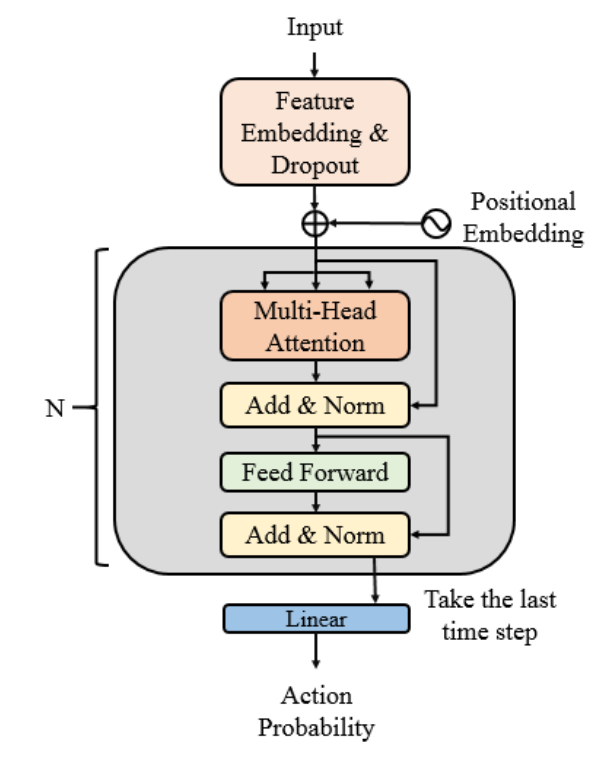

baseline dari arsitektur Transformer menggunakan satu layer Conv1D pada bagian Feed Forward dengan Activation function menggunakan ReLU dan bagian node perceptron pada output disesuaikan dengan horizon datanya. Baseline juga terdapat layer multi-Head Attention digunkan dalam lapisan encoder dan decoder untuk memproses lebih baik dari input dan memperoleh hasil yang lebih baik.
Pada Baseline Model didapat hasil yang sedikit lebih tinggi daripada tuning model, itu berarti Tuning model sudah berjalan dengan baik dan mempunyai arsitektur yang lebih baik daripada baseline. karena Tuning dapat mengalahkan Baseline model Arsitektur Attention.

Model baseline Transformer untuk dataset Amazon terdiri dari lapisan sesuai gambar diatas :          
1. Lapisan Embedding digunakan untuk menromalkan lapisan input menggunakan LayerNormalization dan lapisan pertama dalam model.
2. Lapisan Attention menggunakan MultiHeadAttention untuk menerima input x dan melakukan operasi attention.
3. Lapisan Add & Norm, pada lapisan ini attention layer atau nilai x ditambahkan dengan input.
4. Feed forward yang melakukan operasi feed forward pada nilai x menggunakan satu lapisan Conv1D dan fungsi aktivasi ReLU.
5. Lapisan terakhir adalah Add & Norm. Layer ini menambahkan hasil dengan layer add & norm sebelumnya. kemudian melakukan normalisasi data dengan LayerNormalization.  

Referensi :
*Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.

Narang, S., Chung, H. W., Tay, Y., Fedus, W., Fevry, T., Matena, M., ... & Raffel, C. (2021). Do transformer modifications transfer across implementations and applications?. arXiv preprint arXiv:2102.11972. *

In [ ]:
def build_model_x(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diatas digunakan untuk membangun model Transformer dari lapisan Encoder dan untuk membuat model transfomer yang bisa di setting untuk jumlah, ukuran dan lainnya.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
modelBaseline = build_model_x(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

modelBaseline.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)

modelBaseline.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        19321       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [ ]:
history = modelBaseline.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/5
230/230 [==============================] - 49s 175ms/step - loss: 0.1974 - mae: 0.1974 - val_loss: 0.4160 - val_mae: 0.4160 - lr: 1.0000e-06
Epoch 2/5
230/230 [==============================] - 32s 140ms/step - loss: 0.0804 - mae: 0.0804 - val_loss: 0.0289 - val_mae: 0.0289 - lr: 3.4300e-05
Epoch 3/5
230/230 [==============================] - 30s 131ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0184 - val_mae: 0.0184 - lr: 6.7600e-05
Epoch 4/5
230/230 [==============================] - 32s 137ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0262 - val_mae: 0.0262 - lr: 1.0090e-04
Epoch 5/5
230/230 [==============================] - 33s 142ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0241 - val_mae: 0.0241 - lr: 1.3420e-04


In [ ]:
# Evaluate the model on the test set
TestLoss = modelBaseline.evaluate(x_test, y_test)
print("Test Loss:", TestLoss)

18/18 [==============================] - 1s 70ms/step - loss: 0.0429 - mae: 0.0429
Test Loss: [0.04291554540395737, 0.04291554540395737]


In [ ]:
# Evaluate the model on the test set
TestLoss = modelBaseline.evaluate(x_test, y_test)
print("Test Loss:", TestLoss)

18/18 [==============================] - 3s 172ms/step - loss: 0.0374 - mae: 0.0374
Test Loss: [0.037373557686805725, 0.037373557686805725]


In [ ]:
BaselineAMZN = modelBaseline.predict(x_test)
actualAMZN = np.argmax(x_test, axis=1)
baseline = np.argmax(BaselineAMZN, axis=1)
print("Ground Truth:", actualAMZN)
print("Predicted Result:", baseline)


Ini merupakan Ground Truth dan Predicted Result menggunakan model  

Didapatkan hasil Baseline dari arsitektur Transformer, yaitu:
- RMSE 60%
- MAE 57%
- MAPE 10%

hasil masih belum dapat dikatakan baik. sekarang kita akan membuat modifikasi dari arsitektur tersebut.


# C. Modifikasi Aesitektur

# Dataset Amazon

## Modifikasi 1

In [ ]:
def transformerModif(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res1 = x + inputs

    # Additional Attention Layer
    x = layers.LayerNormalization(epsilon=1e-6)(res1)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res2 = x + res1

    # FEED FORWARD Part
    x = layers.LayerNormalization(epsilon=1e-6)(res2)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res2


Pada arsitektur modifikasi pertama saya menambahkan attention layer untuk agar model lebih fokus pada bagian input. pada pemprosesan attention juga memberikan representasi lebih real. kemudian dengan ini diharapkan model dapat memahami lebih baik tentang relasi titik di input.

kemudian, saya juga menambakan layer dropout dan convolution 1D di bagian feed forward.

Dropout saya gunakan untuk menghilangkan node dari layer sebelumnya, dengan tujuan mengurangi overfitting cara ini terbukti pada paper Srivastava et.al.

*Referensi : Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.*

In [ ]:
def build_modif1(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformerModif(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diata digunakan untuk memodifikasi model transformer. pada modifikasi ini saya  tidak memakai dropout sehingga dituliskan 0.
Adapun parameter-parameter yang digunakan seperti
- 'input_shape' untuk menentukkan shape input data.
- 'head_size', 'num_heads', 'ff_dim' parameter-parameter ini dipakai untuk mengatur konfigurasi dari layer Transformator.
- 'mlp_units' adalah besar dari setiap lapisan dense untuk mengatur jumlah neuron dari lapisan dense.
- 'num_transformer_blocks' menentukan jumlah blok Transformer.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model_modif1 = build_modif1(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model_modif1.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)

model_modif1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_20 (LayerN  (None, 8, 1)        2           ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_10 (Multi  (None, 8, 1)        19321       ['layer_normalization_20[0][0]', 
 HeadAttention)                                                   'layer_normalization_20[0][0]'] 
                                                                                            

In [ ]:
historyModif1 = model_modif1.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/5
230/230 [==============================] - 86s 323ms/step - loss: 0.1990 - mae: 0.1990 - val_loss: 0.4248 - val_mae: 0.4248 - lr: 1.0000e-06
Epoch 2/5
230/230 [==============================] - 61s 264ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0358 - val_mae: 0.0358 - lr: 3.4300e-05
Epoch 3/5
230/230 [==============================] - 64s 278ms/step - loss: 0.0417 - mae: 0.0417 - val_loss: 0.0271 - val_mae: 0.0271 - lr: 6.7600e-05
Epoch 4/5
230/230 [==============================] - 58s 254ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0274 - val_mae: 0.0274 - lr: 1.0090e-04
Epoch 5/5
230/230 [==============================] - 61s 266ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0251 - val_mae: 0.0251 - lr: 1.3420e-04


In [ ]:
# Evaluate the model on the test set
TessLossModif1 = model_modif1.evaluate(x_test, y_test)
print("Test Loss:", TessLossModif1)

18/18 [==============================] - 3s 154ms/step - loss: 0.0453 - mae: 0.0453
Test Loss: [0.045295681804418564, 0.045295681804418564]


Dalam versi modifikasi ini, saya menambahkan  lapisan attention tambahan setelah lapisan attention pertama. Hal ini memungkinkan interaksi yang lebih kompleks dan berpotensi meningkatkan kinerja model. Selain itu, lapisan konvolusi tambahan dengan aktivasi ReLU ditambahkan di bagian feed-forward untuk menangkap lebih jauh pola non-linear. Namun memang saya tidak memodifikasi pada bagian hyperparameter. karena saya ingin bereksperimen apakah dengan menambahkan lapisan attention, lapisan konvolusi (ReLu) di bagian feed-forward akan memberikan hasil yang lebih bagus atau tidak. ternyata dari percobaan tidak begitu mempengaruhi hasil akhirnya.


referensi :   
*Narang, S., Chung, H. W., Tay, Y., Fedus, W., Fevry, T., Matena, M., ... & Raffel, C. (2021). Do transformer modifications transfer across implementations and applications?. arXiv preprint arXiv:2102.11972.*


## Modifikasi 2

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, activation="relu"):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Attention Layer
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Feed Forward Part
    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(attention_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(ff_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    transformer_output = layers.Add()([ff_output, attention_output])
    classification_output = layers.Dense(1, activation="sigmoid")(transformer_output)

    return classification_output


Pada Modifikasi yang ke-2 ada beberapa modifikasi yang dilakukan pada function transfomer_encoder, yaitu:   
1. attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x): Hasil Attention ditambahkan dengan input awal, kemudian dilakukan normalisasi menggunakan LayerNormalization.
2. melakukan normalisasi setelah layer attention dengan menggunakan LayerNormalization.
3. setelah feed-forward menambahkan residual connected. Tujuannya adalah untuk membantu memudahkan aliran gradien dan agar informasi yang terkait dapat bertahan dalam pemrosesan pembelajaran.
4. pada layer feed forward juga ditambahkan normalisasi batch pada output Conv1D menggunakan BatchNormalization.
5. pada 'transformer_output' dilakukan penjumlahan antara output dari lapisan Feed Forward dan output dari lapisan Attention.

dengan modifikasi ini diharapkan mendapatkan hasil yang lebih rendah daripada baseline.

Referensi :
*Lin, T., Wang, Y., Liu, X., & Qiu, X. (2022). A survey of transformers. AI Open.*

In [ ]:
def modif2_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diata digunakan untuk memodifikasi model transformer. pada modifikasi ini saya  tidak memakai dropout sehingga dituliskan 0.
Adapun parameter-parameter yang digunakan seperti
- 'input_shape' untuk menentukkan shape input data.
- 'head_size', 'num_heads', 'ff_dim' parameter-parameter ini dipakai untuk mengatur konfigurasi dari layer Transformator.
- 'mlp_units' adalah besar dari setiap lapisan dense untuk mengatur jumlah neuron dari lapisan dense.
- 'num_transformer_blocks' menentukan jumlah blok Transformer.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model_2 = modif2_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model_2.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)
model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_60 (LayerN  (None, 8, 1)        2           ['input_19[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_30 (Multi  (None, 8, 1)        19321       ['layer_normalization_60[0][0]', 
 HeadAttention)                                                   'layer_normalization_60[0][0]'] 
                                                                                            

In [ ]:
history_Modif2 = model_2.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/3
230/230 [==============================] - 39s 142ms/step - loss: 0.2141 - mae: 0.2141 - val_loss: 0.3698 - val_mae: 0.3698 - lr: 1.0000e-06
Epoch 2/3
230/230 [==============================] - 33s 145ms/step - loss: 0.1929 - mae: 0.1929 - val_loss: 0.3054 - val_mae: 0.3054 - lr: 3.4300e-05
Epoch 3/3
230/230 [==============================] - 32s 139ms/step - loss: 0.1881 - mae: 0.1881 - val_loss: 0.3449 - val_mae: 0.3449 - lr: 6.7600e-05


* Model ditraining dengan 3 iterasi karena memakan banyak komputasi untuk itu, serta batch_size yang dipakai sebesar 30.



In [ ]:
# Evaluate the model on the test set
Modif2 = model_2.evaluate(x_test, y_test)
print("Test Loss:", TessLossModif1)

18/18 [==============================] - 1s 66ms/step - loss: 0.4716 - mae: 0.4716
Test Loss: [0.045295681804418564, 0.045295681804418564]


Test Loss merupakan pengukuran seberapa jauh nilai sebenanrya dengan nilai prediksi. semakin kecil nilainya akan semakin bagus pengukurannya. untuk output diatas sudah terbilang kecil yaitu 0,4% yang artinya tes loss sendiri sudah bagus. Nilai loss pada test set digunakan untuk mengevaluasi model.

referensi :

*Oh, H. W., Yoon, E. S., & Chung, M. K. (1997). An optimum set of loss models for performance prediction of centrifugal compressors. Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy, 211(4), 331-338.*

In [ ]:
modifikasipredictions2 = model_2.predict(x_test)

18/18 [==============================] - 2s 63ms/step


In [ ]:

rmse = np.sqrt(mean_squared_error(y_test, modifikasipredictions2))
mae = mean_absolute_error(y_test, modifikasipredictions2)
mape = mean_absolute_percentage_error(y_test, modifikasipredictions2)

print("Modify Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

Modify Model:
RMSE: 0.5431465073262999
MAE: 0.510573599563848
MAPE: 0.9194575680559335


Pada Modifikasi yang ke-2 ada beberapa modifikasi yang dilakukan pada function transfomer_encoder, yaitu:   
1. penambahan residual connected
2. melakukan normalisasi setelah layer attention
3. setelah feed-forward menambahkan residual connected.
4. terakhir melakukan normalisasi setelah feed forward, dengan tujuan menjaga konsistensi distribusi data yang ada.

dengan modifikasi ini diharapkan mendapatkan hasil yang lebih rendah daripada baseline.

Namun hasil yang didapat tidaklah sesuai harapan. modifikasi ke-2 tidak lebih rendah daripada arsitektur baseline maupun modifikasi pertama.

## Modifikasi 3

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, activation="relu"):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Attention Layer
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Feed Forward Part
    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(attention_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(ff_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    transformer_output = layers.Add()([ff_output, attention_output])
    classification_output = layers.Dense(1, activation="sigmoid")(transformer_output)

    return classification_output


Pada Arsitektur yang ke-3 menambahkan beberapa layer tambahan, seperti
1. lapisan attention dan juga output attention ditambahkan dengan input asli 'attention_output + x'.
2. selain itu residual connection digunakan dalam penjumlahan akhir dengan output dari bagian feed-forward menggunakan 'layer.Add().
3. saya juga menambahkan normalisasi batch dengan tujuan mengurangi ketergantungan pada distribusi input dan mempercepat proses pelatihan
4. pada bagian layer feed forward menambahkan 1 dropout dan juga menambahkan 1 transformasi linear dan activation sigmoid.

dalam paper Svozil et.al., dibahas bahwa beberapa masalah dalam memilih model ataupun tambahan arsitektur adalah berapa banyak layer yang ada. dalam jaringan saraf sendiri jaringan dengan fungsi aktivasi merupakan jumlah unit yang besar.

referensi :
Svozil, D., Kvasnicka, V., & Pospichal, J. (1997). Introduction to multi-layer feed-forward neural networks. Chemometrics and intelligent laboratory systems, 39(1), 43-62.

In [ ]:
def modify_3(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diata digunakan untuk memodifikasi model transformer. pada modifikasi ini saya tidak memakai dropout sehingga ditulis 0. alasan saya menghilangkan dropout adalah dalam paper yang saya baca yaitu  Bell et.al.,  dengan memakainya dropout bisa mengalami bias itulah salah satu alasan say tidak mengambahkan bias karena ingin berekxperimen apakah akan mendapatkan evaluasi model yang lebih rendah.
Adapun parameter-parameter yang digunakan seperti
- 'input_shape' untuk menentukkan shape input data.
- 'head_size', 'num_heads', 'ff_dim' parameter-parameter ini dipakai untuk mengatur konfigurasi dari layer Transformator.
- 'mlp_units' adalah besar dari setiap lapisan dense untuk mengatur jumlah neuron dari lapisan dense.
- 'num_transformer_blocks' menentukan jumlah blok Transformer.


Bell, M. L., Kenward, M. G., Fairclough, D. L., & Horton, N. J. (2013). Differential dropout and bias in randomised controlled trials: when it matters and when it may not. Bmj, 346.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model3 = modify_3(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model3.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"],
)

model3.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_90 (LayerN  (None, 8, 1)        2           ['input_22[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_45 (Multi  (None, 8, 1)        19321       ['layer_normalization_90[0][0]', 
 HeadAttention)                                                   'layer_normalization_90[0][0]'] 
                                                                                            

In [ ]:
history_3 = model3.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=32,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/2
144/144 [==============================] - 32s 220ms/step - loss: 0.3105 - mae: 0.3105 - val_loss: 0.5236 - val_mae: 0.5236 - lr: 1.0000e-06
Epoch 2/2
144/144 [==============================] - 32s 224ms/step - loss: 0.2146 - mae: 0.2146 - val_loss: 0.3034 - val_mae: 0.3034 - lr: 3.4300e-05


In [ ]:
# Evaluate the model on the test set
TestLoss = model3.evaluate(x_test, y_test)
print("Test Loss:", TestLoss)

18/18 [==============================] - 5s 74ms/step - loss: 0.6788 - mae: 0.6788
Test Loss: [0.678811252117157, 0.678811252117157]


Test Loss merupakan pengukuran seberapa jauh nilai sebenanrya dengan nilai prediksi. semakin kecil nilainya akan semakin bagus pengukurannya. untuk output diatas sudah terbilang kecil yaitu 6.7%% lebih besar daripada modifikasi ke-2 yang artinya pada model modifikasi ke-3 masih dibawah modifikasi ke-2.

referensi :

*Oh, H. W., Yoon, E. S., & Chung, M. K. (1997). An optimum set of loss models for performance prediction of centrifugal compressors. Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy, 211(4), 331-338.*

In [ ]:
# Matric Eval dalam test set

# Predict on the test set
baseline_predictions1 = model3.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions1))
baseline_mae = mean_absolute_error(y_test, baseline_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, baseline_predictions1)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

18/18 [==============================] - 3s 111ms/step
Baseline Model:
RMSE: 0.457036004688076
MAE: 0.4220837581296884
MAPE: 0.857550506092802


Pada Arsitektur yang ke-3 menambahkan beberapa layer tambahan, seperti
1. lapisan attention dan juga output attention ditambahkan dengan input asli 'attention_output + x'.
2. selain itu residual connection digunakan dalam penjumlahan akhir dengan output dari bagian feed-forward menggunakan 'layer.Add().
3. saya juga menambahkan normalisasi batch dengan tujuan mengurangi ketergantungan pada distribusi input dan mempercepat proses pelatihan
4. pada bagian layer feed forward menambahkan 1 dropout dan juga menambahkan 1 transformasi linear dan activation sigmoid.

Hasil dari Arsitektur modify ke-3 sebesar
- RMSE 45%
- MAE 42%
- MAPE 85%
tidak cukup baik daripada sebelumnya. sehingga dalam modifikasi untuk data Amazon yang paling bagu adalah modifikasi pertama. dengan arsitektur Pada arsitektur modifikasi pertama saya menambahkan attention layer untuk agar model lebih fokus pada bagian input. pada pemprosesan attention juga memberikan representasi lebih real. kemudian dengan ini diharapkan model dapat memahami lebih baik tentang relasi titik di inpput.

kemudian, saya juga menambakan layer dropout dan convolution 1D di bagian feed forward.

Dropout saya gunakan untuk menghilangkan node dari layer sebelumnya, dengan tujuan mengurangi overfitting cara ini terbukti pada paper Srivastava et.al.

*Referensi : Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.*

In [ ]:
# Matric Eval dalam test set

# Predict on the test set
baseline_predictions1 = modelBaseline.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions1))
baseline_mae = mean_absolute_error(y_test, baseline_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, baseline_predictions1)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

18/18 [==============================] - 2s 66ms/step
Baseline Model:
RMSE: 0.05925470901130825
MAE: 0.042915541423656285
MAPE: 0.10178843711006433


# Dataset CISCO

In [ ]:
dfAMZN = pd.read_csv("CSCO.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
dfAMZN.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


In [ ]:
# Buat variabel baru yang berisi
pricesCisco = pd.DataFrame(dfAMZN["Close"]).rename(columns={"Close": "Price"})
pricesCisco.head()

,Price
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


In [ ]:
WINDOW_SIZE = 5
HORIZON = 1

- Window size : rentang dari senin hingga jumat
- Horizon hanya hari senin saja

In [ ]:
# Get AMZN date array
timesteps = pricesCisco.index.to_numpy()
prices1 = pricesCisco["Price"].to_numpy()

timesteps[:10], prices1[:10]

(array(['1990-02-16T00:00:00.000000000', '1990-02-20T00:00:00.000000000',
        '1990-02-21T00:00:00.000000000', '1990-02-22T00:00:00.000000000',
        '1990-02-23T00:00:00.000000000', '1990-02-26T00:00:00.000000000',
        '1990-02-27T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
        '1990-03-01T00:00:00.000000000', '1990-03-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
        0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

In [ ]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(6)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5] -> Label: 6


In [ ]:
def make_windows(x, window_size=5, horizon=1):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows1, full_labels1 = make_windows(prices1, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows1), len(full_labels1)

(7584, 7584)

## Create split train tes val

In [ ]:
def make_train_val_test_splits(windows, labels, val_split=0.1, test_split=0.1):

    total_size = len(windows)
    train_size = int(total_size * 0.8)
    val_size = int(total_size * 0.1)
    test_size = total_size - train_size - val_size

    train_windows = windows[:train_size]
    train_labels = labels[:train_size]
    val_windows = windows[train_size:train_size+val_size]
    val_labels = labels[train_size:train_size+val_size]
    test_windows = windows[train_size+val_size:]
    test_labels = labels[train_size+val_size:]

    return train_windows, val_windows, test_windows, train_labels, val_labels, test_labels

In [ ]:
train_windows1, val_windows1, test_windows1, train_labels1, val_labels1, test_labels1= make_train_val_test_splits(full_windows1, full_labels1)
print("Train set length:", len(train_windows1))
print("Validation set length:", len(val_windows1))
print("Test set length:", len(test_windows1))
print("Train labels length:", len(train_labels1))
print("Validation labels length:", len(val_labels1))
print("Test labels length:", len(test_labels1))

Train set length: 6067
Validation set length: 758
Test set length: 759
Train labels length: 6067
Validation labels length: 758
Test labels length: 759


In [ ]:
print('Train set: {} baris x {} kolom'.format(train_windows1.shape[0], train_windows1.shape[1]))
print('Test set: {} baris x {} kolom'.format(test_windows1.shape[0], test_windows1.shape[1]))
print('Validation set: {} baris x {} kolom'.format(val_windows1.shape[0], val_windows1.shape[1]))

Train set: 6067 baris x 5 kolom
Test set: 759 baris x 5 kolom
Validation set: 758 baris x 5 kolom


In [ ]:
# Scaling training set
scaled = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaled.fit_transform(train_windows1)
test_set_scaled = scaled.fit_transform(test_windows1)
val_set_scaled = scaled.fit_transform(val_windows1)

In [ ]:
timesteps = 8

x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for i in range(timesteps,train_windows1.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

for i in range(timesteps,test_windows1.shape[0]):
    x_test.append(test_set_scaled[i-timesteps:i,0])
    y_test.append(test_set_scaled[i,0])
x_test, y_test = np.array(x_test), np.array(y_test)

for i in range(timesteps,val_windows1.shape[0]):
    x_val.append(val_set_scaled[i-timesteps:i,0])
    y_val.append(val_set_scaled[i,0])
x_val, y_val = np.array(x_val), np.array(y_val)


print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

print(x_test[0], y_test[0])
print(x_test[1], y_test[1])

print(x_val[0], y_val[0])
print(x_val[1], y_val[1])

[7.59631864e-05 1.08518771e-04 8.68150170e-05 9.76668475e-05
 9.22409323e-05 6.51112627e-05 8.68150170e-05 1.19370602e-04] 0.0001085187712203757
[1.08518771e-04 8.68150170e-05 9.76668475e-05 9.22409323e-05
 6.51112627e-05 8.68150170e-05 1.19370602e-04 1.08518771e-04] 0.0001193706017712313
[0.12680637 0.13475426 0.12969648 0.13403184 0.13078038 0.13186416
 0.12174859 0.12174859] 0.12391613426164061
[0.13475426 0.12969648 0.13403184 0.13078038 0.13186416 0.12174859
 0.12174859 0.12391613] 0.11596825063664995
[0.00466196 0.00466196 0.02020204 0.00543898 0.         0.0598291
 0.05827506 0.0349651 ] 0.059052081737083206
[0.00466196 0.02020204 0.00543898 0.         0.0598291  0.05827506
 0.0349651  0.05905208] 0.0660451011665506


In [ ]:
print("Train Shape : ")
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)
print("")

print("Test Shape : ")
print(x_test.shape, y_test.shape)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape, y_test.shape)
print("")

print("Val Shape : ")
print(x_val.shape, y_val.shape)
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
print(x_val.shape, y_val.shape)
print("")



print("Train shape : ")
print(x_train.shape, y_train.shape)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

print("Test shape : ")
print(x_test.shape, y_test.shape)
idx = np.random.permutation(len(x_test))
x_test = x_test[idx]
y_test = y_test[idx]

print("Val shape : ")
print(x_val.shape, y_val.shape)
idx = np.random.permutation(len(x_val))
x_val = x_val[idx]
y_val = y_val[idx]

Train Shape : 
(6059, 8, 1) (6059,)
(6059, 8, 1) (6059,)

Test Shape : 
(751, 8, 1) (751,)
(751, 8, 1) (751,)

Val Shape : 
(750, 8, 1) (750,)
(750, 8, 1) (750,)

Train shape : 
(6059, 8, 1) (6059,)
Test shape : 
(751, 8, 1) (751,)
Val shape : 
(750, 8, 1) (750,)


## Baseline Arsitektur Cisco

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

Model baseline Transformer untuk dataset Amazon terdiri dari lapisan sesuai gambar diatas :          
1. Lapisan Embedding digunakan untuk menromalkan lapisan input menggunakan LayerNormalization dan lapisan pertama dalam model.
2. Lapisan Attention menggunakan MultiHeadAttention untuk menerima input x dan melakukan operasi attention.
3. Lapisan Add & Norm, pada lapisan ini attention layer atau nilai x ditambahkan dengan input.
4. Feed forward yang melakukan operasi feed forward pada nilai x menggunakan satu lapisan Conv1D dan fungsi aktivasi ReLU.
5. Lapisan terakhir adalah Add & Norm. Layer ini menambahkan hasil dengan layer add & norm sebelumnya. kemudian melakukan normalisasi data dengan LayerNormalization.  

In [ ]:
def build_model_x(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
modelBaseline = build_model_x(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

modelBaseline.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)

modelBaseline.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_100 (Layer  (None, 8, 1)        2           ['input_23[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_50 (Multi  (None, 8, 1)        19321       ['layer_normalization_100[0][0]',
 HeadAttention)                                                   'layer_normalization_100[0][0]']
                                                                                            

In [ ]:
history = modelBaseline.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/5
303/303 [==============================] - 121s 371ms/step - loss: 0.1049 - mae: 0.1049 - val_loss: 0.2263 - val_mae: 0.2263 - lr: 1.0000e-06
Epoch 2/5
303/303 [==============================] - 44s 146ms/step - loss: 0.0520 - mae: 0.0520 - val_loss: 0.0467 - val_mae: 0.0467 - lr: 3.4300e-05
Epoch 3/5
303/303 [==============================] - 43s 141ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0523 - val_mae: 0.0523 - lr: 6.7600e-05
Epoch 4/5
303/303 [==============================] - 45s 150ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0515 - val_mae: 0.0515 - lr: 1.0090e-04
Epoch 5/5
303/303 [==============================] - 44s 146ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0393 - val_mae: 0.0393 - lr: 1.3420e-04


In [ ]:
# Evaluate the model on the test set
TestLoss = modelBaseline.evaluate(x_test, y_test)
print("Test Loss:", TestLoss)

24/24 [==============================] - 2s 67ms/step - loss: 0.0352 - mae: 0.0352
Test Loss: [0.0352291576564312, 0.0352291576564312]


Test Loss merupakan pengukuran seberapa jauh nilai sebenanrya dengan nilai prediksi. semakin kecil nilainya akan semakin bagus pengukurannya. untuk output diatas sudah terbilang kecil yaitu 0,3% yang artinya tes loss sendiri sudah bagus. Nilai loss pada test set digunakan untuk mengevaluasi model.

referensi :

*Oh, H. W., Yoon, E. S., & Chung, M. K. (1997). An optimum set of loss models for performance prediction of centrifugal compressors. Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy, 211(4), 331-338.*

## Modifikasi ke-1

In [ ]:
def transformerModif(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res1 = x + inputs

    # Additional Attention Layer
    x = layers.LayerNormalization(epsilon=1e-6)(res1)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res2 = x + res1

    # FEED FORWARD Part
    x = layers.LayerNormalization(epsilon=1e-6)(res2)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res2


Pada percobaan modifikasi data Cisco yang pertama, perubahan ini yang saya lakukan :        
- saya membuang dropout pada feed forward
- menambahkan attention layer berupa:
  1.  dengan normalisasi dan embedding layer untuk menjaga konsistensi distribusi data.
  2. menambahkan Attention Layer, kemudian output tersebut dimasukkan ke dropout layer.
  3. saya juga menambahkan residual connection menggunakan `+` untuk menyimpan data asli dan membantu aliran gradien selama proses pembelajaran.

referensi
  Narang, S., Chung, H. W., Tay, Y., Fedus, W., Fevry, T., Matena, M., ... & Raffel, C. (2021). Do transformer modifications transfer across implementations and applications?. arXiv preprint arXiv:2102.11972.

In [ ]:
def build_modif1(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=2,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformerModif(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diata digunakan untuk memodifikasi model transformer. pada modifikasi ini saya  memakai dropout sebesar 2.
Adapun parameter-parameter yang digunakan seperti
- 'input_shape' untuk menentukkan shape input data.
- 'head_size', 'num_heads', 'ff_dim' parameter-parameter ini dipakai untuk mengatur konfigurasi dari layer Transformator.
- 'mlp_units' adalah besar dari setiap lapisan dense untuk mengatur jumlah neuron dari lapisan dense.
- 'num_transformer_blocks' menentukan jumlah blok Transformer.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model_modif1 = build_modif1(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model_modif1.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)

model_modif1.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_145 (Layer  (None, 8, 1)        2           ['input_27[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_75 (Multi  (None, 8, 1)        19321       ['layer_normalization_145[0][0]',
 HeadAttention)                                                   'layer_normalization_145[0][0]']
                                                                                           

In [ ]:
historyModif1 = model_modif1.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/3
303/303 [==============================] - 92s 272ms/step - loss: 0.2126 - mae: 0.2126 - val_loss: 0.4831 - val_mae: 0.4831 - lr: 1.0000e-06
Epoch 2/3
303/303 [==============================] - 80s 265ms/step - loss: 0.0956 - mae: 0.0956 - val_loss: 0.0875 - val_mae: 0.0875 - lr: 3.4300e-05
Epoch 3/3
303/303 [==============================] - 78s 257ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0337 - val_mae: 0.0337 - lr: 6.7600e-05


In [ ]:
# Evaluate the model on the test set
TessLossModif1 = model_modif1.evaluate(x_test, y_test)
print("Test Loss:", TessLossModif1)

24/24 [==============================] - 3s 118ms/step - loss: 0.0297 - mae: 0.0297
Test Loss: [0.029742585495114326, 0.029742585495114326]


Test Loss merupakan pengukuran seberapa jauh nilai sebenanrya dengan nilai prediksi. semakin kecil nilainya akan semakin bagus pengukurannya. untuk output diatas sudah terbilang kecil yaitu 0,2% yang artinya tes loss sendiri sudah bagus. Nilai loss pada test set digunakan untuk mengevaluasi model.

referensi :

*Oh, H. W., Yoon, E. S., & Chung, M. K. (1997). An optimum set of loss models for performance prediction of centrifugal compressors. Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy, 211(4), 331-338.*

## Modifikasi ke-2

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, activation="relu"):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Attention Layer
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Feed Forward Part
    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(attention_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(ff_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    transformer_output = layers.Add()([ff_output, attention_output])
    classification_output = layers.Dense(1, activation="sigmoid")(transformer_output)

    return classification_output


Pada Modifikasi yang ke-2 ada beberapa modifikasi yang dilakukan pada function transfomer_encoder, yaitu:   
1. attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x): Hasil Attention ditambahkan dengan input awal, kemudian dilakukan normalisasi menggunakan LayerNormalization.
2. melakukan normalisasi setelah layer attention dengan menggunakan LayerNormalization.
3. setelah feed-forward menambahkan residual connected. Tujuannya adalah untuk membantu memudahkan aliran gradien dan agar informasi yang terkait dapat bertahan dalam pemrosesan pembelajaran.
4. pada layer feed forward juga ditambahkan normalisasi batch pada output Conv1D menggunakan BatchNormalization.
5. pada 'transformer_output' dilakukan penjumlahan antara output dari lapisan Feed Forward dan output dari lapisan Attention.

dengan modifikasi ini diharapkan mendapatkan hasil yang lebih rendah daripada baseline.

Referensi :
*Lin, T., Wang, Y., Liu, X., & Qiu, X. (2022). A survey of transformers. AI Open.*

In [ ]:
def modif2_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diata digunakan untuk memodifikasi model transformer. pada modifikasi ini saya tidak memakai dropout sehingga ditulis 0.
Adapun parameter-parameter yang digunakan seperti
- 'input_shape' untuk menentukkan shape input data.
- 'head_size', 'num_heads', 'ff_dim' parameter-parameter ini dipakai untuk mengatur konfigurasi dari layer Transformator.
- 'mlp_units' adalah besar dari setiap lapisan dense untuk mengatur jumlah neuron dari lapisan dense.
- 'num_transformer_blocks' menentukan jumlah blok Transformer.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model_2 = modif2_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model_2.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],
)
model_2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_125 (Layer  (None, 8, 1)        2           ['input_25[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_65 (Multi  (None, 8, 1)        19321       ['layer_normalization_125[0][0]',
 HeadAttention)                                                   'layer_normalization_125[0][0]']
                                                                                           

In [ ]:
history_Modif2 = model_2.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/3
303/303 [==============================] - 57s 157ms/step - loss: 0.3425 - mae: 0.3425 - val_loss: 0.5890 - val_mae: 0.5890 - lr: 1.0000e-06
Epoch 2/3
303/303 [==============================] - 43s 141ms/step - loss: 0.1814 - mae: 0.1814 - val_loss: 0.3104 - val_mae: 0.3104 - lr: 3.4300e-05
Epoch 3/3
303/303 [==============================] - 44s 145ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.2978 - val_mae: 0.2978 - lr: 6.7600e-05


In [ ]:
# Evaluate the model on the test set
Modif2 = model_2.evaluate(x_test, y_test)
print("Test Loss:", TessLossModif1)

24/24 [==============================] - 2s 66ms/step - loss: 0.3344 - mae: 0.3344
Test Loss: [0.03982545807957649, 0.03982545807957649]


Test Loss merupakan pengukuran seberapa jauh nilai sebenanrya dengan nilai prediksi. semakin kecil nilainya akan semakin bagus pengukurannya. untuk output diatas sudah terbilang kecil yaitu 0,3% yang artinya tes loss sendiri sudah bagus. Nilai loss pada test set digunakan untuk mengevaluasi model.

referensi :

*Oh, H. W., Yoon, E. S., & Chung, M. K. (1997). An optimum set of loss models for performance prediction of centrifugal compressors. Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy, 211(4), 331-338.*

In [ ]:
#modifiikasi data cisco
modifikasipredictions2 = model_2.predict(x_test)


rmse = np.sqrt(mean_squared_error(y_test, modifikasipredictions2))
mae = mean_absolute_error(y_test, modifikasipredictions2)
mape = mean_absolute_percentage_error(y_test, modifikasipredictions2)

print("Modify Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

24/24 [==============================] - 3s 73ms/step
Modify Model:
RMSE: 0.052564227652386976
MAE: 0.039825460310895004
MAPE: 247285641777.9027


Pada modifikasi ke-2 arsitektur Transformer didapatkan hasil :                    
- RMSE 0,5 % yang artinya sudah terbilang kecil
- MAE 0,3% MAE juga dapat dikatakan kecil.
- MAPE 24% artinya dapat dibilang lumayan besar.

## modifikasi ke 3

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, activation="relu"):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Attention Layer
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Feed Forward Part
    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(attention_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation)(ff_output)
    ff_output = layers.BatchNormalization()(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)

    transformer_output = layers.Add()([ff_output, attention_output])
    classification_output = layers.Dense(1, activation="sigmoid")(transformer_output)

    return classification_output


Pada Arsitektur yang ke-3 menambahkan beberapa layer tambahan, seperti
1. lapisan attention dan juga output attention ditambahkan dengan input asli 'attention_output + x'.
2. selain itu residual connection digunakan dalam penjumlahan akhir dengan output dari bagian feed-forward menggunakan 'layer.Add().
3. saya juga menambahkan normalisasi batch dengan tujuan mengurangi ketergantungan pada distribusi input dan mempercepat proses pelatihan
4. pada bagian layer feed forward menambahkan 1 dropout dan juga menambahkan 1 transformasi linear dan activation sigmoid.



In [ ]:
def modify_3(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


Function diata digunakan untuk memodifikasi model transformer. pada modifikasi ini saya tidak memakai dropout sehingga ditulis 0.
Adapun parameter-parameter yang digunakan seperti
- 'input_shape' untuk menentukkan shape input data.
- 'head_size', 'num_heads', 'ff_dim' parameter-parameter ini dipakai untuk mengatur konfigurasi dari layer Transformator.
- 'mlp_units' adalah besar dari setiap lapisan dense untuk mengatur jumlah neuron dari lapisan dense.
- 'num_transformer_blocks' menentukan jumlah blok Transformer.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model3 = modify_3(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model3.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"],
)

model3.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_135 (Layer  (None, 8, 1)        2           ['input_26[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_70 (Multi  (None, 8, 1)        19321       ['layer_normalization_135[0][0]',
 HeadAttention)                                                   'layer_normalization_135[0][0]']
                                                                                           

In [ ]:
history_3 = model3.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=32,
    callbacks=callbacks,
    validation_data = (x_val, y_val)
)

Epoch 1/2
190/190 [==============================] - 60s 252ms/step - loss: 0.1859 - mae: 0.1859 - val_loss: 0.3748 - val_mae: 0.3748 - lr: 1.0000e-06
Epoch 2/2
190/190 [==============================] - 42s 223ms/step - loss: 0.1646 - mae: 0.1646 - val_loss: 0.3038 - val_mae: 0.3038 - lr: 3.4300e-05


In [ ]:
# Evaluate the model on the test set
TestLoss = model3.evaluate(x_test, y_test)
print("Test Loss:", TestLoss)

24/24 [==============================] - 2s 74ms/step - loss: 0.3384 - mae: 0.3384
Test Loss: [0.3384099006652832, 0.3384099006652832]


Test Loss merupakan pengukuran seberapa jauh nilai sebenanrya dengan nilai prediksi. semakin kecil nilainya akan semakin bagus pengukurannya. untuk output diatas sudah terbilang kecil yaitu 3,3%% tetapi tidak lebih bagus daripada modifikasi pertama yaitu 0,2%.

referensi :

*Oh, H. W., Yoon, E. S., & Chung, M. K. (1997). An optimum set of loss models for performance prediction of centrifugal compressors. Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy, 211(4), 331-338.*

In [ ]:
# Matric Eval dalam test set

# Predict on the test set
baseline_predictions1 = model3.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions1))
baseline_mae = mean_absolute_error(y_test, baseline_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, baseline_predictions1)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

24/24 [==============================] - 3s 69ms/step
Baseline Model:
RMSE: 0.39577612657544126
MAE: 0.33840987619753704
MAPE: 1109053864850.5317


pada performa pengukuran modifikasi ke-3 dilihat hasil MAPE sudah lebih baik dibandingkan sebelumnya yaitu 11% namun RMSE dan MAE meningkat tajam yaitu sebesar 39% dan juga 33%. itu artinya model modifikasi yang paling baik ada pada model modifikasi arsitektur ke-1 yang akan saya bahas lebih lanjut pada bagian evaluasi model itu sendiri.

# D. Evaluasi Model Transformer

### Dataset Amazon

#### Baseline

In [ ]:
# Matric Eval dalam test set

# Predict on the test set
baseline_predictions1 = modelBaseline.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions1))
baseline_mae = mean_absolute_error(y_test, baseline_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, baseline_predictions1)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

18/18 [==============================] - 2s 87ms/step
Baseline Model:
RMSE: 0.6009641199513225
MAE: 0.5706344838451348
MAPE: 1.0188866419093743


#### Tuning Model  

In [ ]:
#Tuning Model
modifikasi_predictions1 = model_modif1.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, modifikasi_predictions1))
baseline_mae = mean_absolute_error(y_test, modifikasi_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, modifikasi_predictions1)

print("Modify Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

18/18 [==============================] - 3s 119ms/step
Modify Model:
RMSE: 0.06235842225245711
MAE: 0.045295680700345016
MAPE: 0.10750118924609536


In [ ]:
import numpy as np

# Persiapkan data uji
x_test = np.array(test_windows1)  # Isi dengan testing set yang sesuai

# Ground Truth
ground_truth = np.array(test_labels1)  # Isi dengan nilai Ground Truth yang sesuai dengan testing set

# Prediksi nilai
print("Shape of x_test:", x_test.shape)

print("Ground Truth:", ground_truth)
print("Predicted Result:", predicted_result)


Shape of x_test: (576, 5)
Ground Truth: [[1179.14001465]
 [1190.57995605]
 [1187.38000488]
 [1177.61999512]
 [1174.76000977]
 [1168.35998535]
 [1176.76000977]
 [1182.26000977]
 [1186.09997559]
 [1169.4699707 ]
 [1189.01000977]
 [1204.19995117]
 [1209.58996582]
 [1229.14001465]
 [1246.86999512]
 [1252.69995117]
 [1254.32995605]
 [1276.68005371]
 [1305.19995117]
 [1304.85998535]
 [1295.        ]
 [1293.31994629]
 [1294.57995605]
 [1327.31005859]
 [1362.54003906]
 [1357.51000977]
 [1377.94995117]
 [1402.05004883]
 [1417.68005371]
 [1437.81994629]
 [1450.89001465]
 [1390.        ]
 [1429.94995117]
 [1390.        ]
 [1442.83996582]
 [1416.7800293 ]
 [1350.5       ]
 [1339.59997559]
 [1386.22998047]
 [1414.51000977]
 [1451.05004883]
 [1461.76000977]
 [1448.68994141]
 [1468.34997559]
 [1482.92004395]
 [1485.33996582]
 [1500.        ]
 [1521.94995117]
 [1511.97998047]
 [1512.44995117]
 [1493.44995117]
 [1500.25      ]
 [1523.60998535]
 [1537.64001465]
 [1545.        ]
 [1551.85998535]
 [1578.8

pada hasil Evaluasi terdapat baseline dan juga Tuning model.
baseline dari arsitektur Transformer menggunakan satu layer Conv1D pada bagian Feed Forward dengan Activation function menggunakan ReLU dan bagian node perceptron pada output disesuaikan dengan horizon datanya. Baseline juga terdapat layer multi-Head Attention digunkan dalam lapisan encoder dan decoder untuk memproses lebih baik dari input dan memperoleh hasil yang lebih baik.
Pada Baseline Model didapat hasil yang sedikit lebih tinggi daripada tuning model, itu berarti Tuning model sudah berjalan dengan baik dan mempunyai arsitektur yang lebih baik daripada baseline. karena Tuning dapat mengalahkan Baseline model Arsitektur Attention.

Dengan Tuning berhasil pada modifikasi pertama yaitu dengan pemodifikasian menambahkan attention layer untuk agar model lebih fokus pada bagian input. pada pemprosesan attention juga memberikan representasi lebih real. kemudian dengan ini diharapkan model dapat memahami lebih baik tentang relasi titik di inpput.

kemudian, saya juga menambakan layer dropout dan convolution 1D di bagian feed forward.

Dropout saya gunakan untuk menghilangkan node dari layer sebelumnya, dengan tujuan mengurangi overfitting cara ini terbukti pada paper Srivastava et.al.

*Referensi : Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.*

### Dataset Cisco

#### Baseline Model

In [ ]:
# Matric Eval dalam test set

# Predict on the test set
baseline_predictions1 = modelBaseline.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions1))
baseline_mae = mean_absolute_error(y_test, baseline_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, baseline_predictions1)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

24/24 [==============================] - 2s 67ms/step
Baseline Model:
RMSE: 0.04936246652260908
MAE: 0.035229160721132316
MAPE: 256365377249.79178


In [ ]:
import numpy as np

# Persiapkan data uji
x_test = np.array(test_windows1)  # Isi dengan testing set yang sesuai

# Ground Truth
ground_truth = np.array(test_labels1)  # Isi dengan nilai Ground Truth yang sesuai dengan testing set

# Prediksi nilai
print("Shape of x_test:", x_test.shape)

print("Ground Truth:", ground_truth)
print("Predicted Result:", predicted_result)


Shape of x_test: (576, 5)
Ground Truth: [[1179.14001465]
 [1190.57995605]
 [1187.38000488]
 [1177.61999512]
 [1174.76000977]
 [1168.35998535]
 [1176.76000977]
 [1182.26000977]
 [1186.09997559]
 [1169.4699707 ]
 [1189.01000977]
 [1204.19995117]
 [1209.58996582]
 [1229.14001465]
 [1246.86999512]
 [1252.69995117]
 [1254.32995605]
 [1276.68005371]
 [1305.19995117]
 [1304.85998535]
 [1295.        ]
 [1293.31994629]
 [1294.57995605]
 [1327.31005859]
 [1362.54003906]
 [1357.51000977]
 [1377.94995117]
 [1402.05004883]
 [1417.68005371]
 [1437.81994629]
 [1450.89001465]
 [1390.        ]
 [1429.94995117]
 [1390.        ]
 [1442.83996582]
 [1416.7800293 ]
 [1350.5       ]
 [1339.59997559]
 [1386.22998047]
 [1414.51000977]
 [1451.05004883]
 [1461.76000977]
 [1448.68994141]
 [1468.34997559]
 [1482.92004395]
 [1485.33996582]
 [1500.        ]
 [1521.94995117]
 [1511.97998047]
 [1512.44995117]
 [1493.44995117]
 [1500.25      ]
 [1523.60998535]
 [1537.64001465]
 [1545.        ]
 [1551.85998535]
 [1578.8

ini merupakan nilai ground dan prediksi resultnya.

#### Tuning Model

In [ ]:
#tuning model
modifikasi_predictions1 = model_modif1.predict(x_test)

# Matric Eval
baseline_rmse = np.sqrt(mean_squared_error(y_test, modifikasi_predictions1))
baseline_mae = mean_absolute_error(y_test, modifikasi_predictions1)
baseline_mape = mean_absolute_percentage_error(y_test, modifikasi_predictions1)

print("Modify Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE:", baseline_mape)

24/24 [==============================] - 4s 116ms/step
Modify Model:
RMSE: 0.0406121328878552
MAE: 0.029742581463814494
MAPE: 218715763097.16583


pada hasil Evaluasi terdapat baseline dan juga Tuning model. baseline dari arsitektur Transformer menggunakan satu layer Conv1D pada bagian Feed Forward dengan Activation function menggunakan ReLU dan bagian node perceptron pada output disesuaikan dengan horizon datanya. Baseline juga terdapat layer multi-Head Attention digunkan dalam lapisan encoder dan decoder untuk memproses lebih baik dari input dan memperoleh hasil yang lebih baik. Pada Baseline Model didapat hasil yang sedikit lebih tinggi daripada tuning model, itu berarti Tuning model sudah berjalan dengan baik dan mempunyai arsitektur yang lebih baik daripada baseline. karena Tuning dapat mengalahkan Baseline model Arsitektur Attention.

Dengan Tuning model mendapatkan hasil yang lebih bagus. Model tuning berhasil pada percobaan modifikasi ke-1 dengan mengubah Pada percobaan modifikasi data Cisco yang pertama, perubahan ini yang saya lakukan :        
- saya membuang dropout pada feed forward
- menambahkan attention layer berupa:
  1.  dengan normalisasi dan embedding layer untuk menjaga konsistensi distribusi data.
  2. menambahkan Attention Layer, kemudian output tersebut dimasukkan ke dropout layer.
  3. saya juga menambahkan residual connection menggunakan `+` untuk menyimpan data asli dan membantu aliran gradien selama proses pembelajaran.

  referensi
  
  *Narang, S., Chung, H. W., Tay, Y., Fedus, W., Fevry, T., Matena, M., ... & Raffel, C. (2021). Do transformer modifications transfer across implementations and applications?. arXiv preprint arXiv:2102.11972.*

Baseline dengan modifikasi arsitektur pertama mendapatkan hasil evaluasi yang lebih baik dibandingkan dengan baseline. ada beberapa teori yang membuktikan bahwa modifikasi ke-1 mendapatkan evaluasi terbaik dalam kedua dataset tersebut.
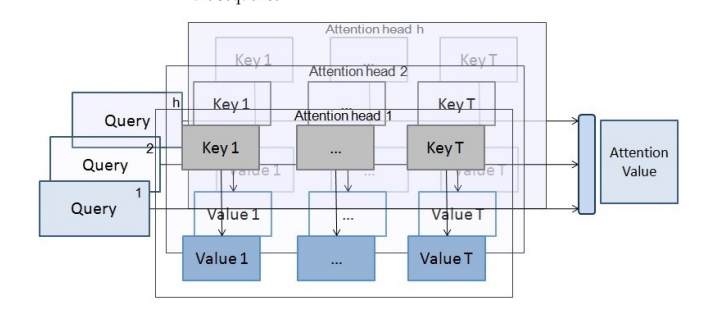

pada paper Hernández et.al., dikatakan dengan jaringan dengan enam lapisan identik yang memiliki perhatian sendiri (self-attention) dan jaringan feed-forward, dengan sub-lapisan ketiga yang melakukan perhatian terhadap output encoder, ini menggambarkan model Transformer yang populer dalam pemrosesan bahasa alami (natural language processing).

Dengan menggunakan Attention, jaringan dapat menyesuaikan bobot atau relevansi setiap elemen dalam urutan data inputnya. Ini memungkinkan jaringan untuk memberikan lebih banyak perhatian pada informasi yang penting dan mengabaikan informasi yang kurang relevan atau noise. Dengan itu penggunaan attention dalam jaringan saraf dapat meningkatkan kemampuan jaringan untuk menangkap pola-pola yang lebih kompleks dan mendasar dalam data inputnya.

rujukan :
Hernández, A., & Amigó, J. M. (2021). Attention mechanisms and their applications to complex systems. Entropy, 23(3), 283.

### E. Link Video : https://youtu.be/DpIhEsz2bsQ